# Rate-distortion theory for minimum information given an average growth rate.

In [1]:
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import pandas as pd

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import sys
sys.path.insert(0, '../../')
import infofit_utils as utils

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/blahut_algorithm_rate_distortion/'
tmpdir = '../../tmp/'

In [2]:
# Set PBoC plotting format
utils.viz.set_plotting_style()

## $\LaTeX$ macros
$\newcommand{\ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\bb}[1]{\mathbf{#1}}$

# Rate distortion theory and the minimum amount of information to sustain an average growth rate

For an ensemble of environments $c$ with probability distribution $P(c)$, we have that the average fitness (growth rate) $\ee{r}$ over the ensemble of environemnts, given an input-output function $P(p \mid c)$ is given by (for continuous case)
\begin{equation}
    \langle r \rangle = \int dc\; P(c) \int dp \;P(p \mid c) r(p, c),
\end{equation}
where $r(p, c)$ is the fitness lanscape function that takes as input the protein expression level $p$ and the environmental state (i.e. concentration of relevant chemical $c$). It is easy to see that not all distributions $P(p \mid c)$ are consistent with a given $\langle r \rangle$. Depending on the environment state distribution $P(c)$ different input-output functions will have different mean fitness values.

An interesting question then is if there is a minimum value of the mutual information between input and output $I(c; p)$ consistent with a value of $\ee{r}$. This question can be mathematically expressed as a constrained optimization problem that happens to be extremely similar to E.T. Jaynes derivation of the Boltzmann distribution, showing again the unity and power of concepts and models in physics.

As shown in Jaynes classic 1957 paper, the Boltzmann distribution is the distribution that maximizes the Shannon information entropy constrained by an average energy $\ee{E}$. This can be written as an unconstrained minimization problem where we define a constrained equation of the form
\begin{equation}
    \mathcal{L} = -\sum_i p_i \ln p_i - \lambda \left( \sum_i i p_i - \langle E \rangle \right) - \mu \left( \sum_i p_i - 1 \right),
\end{equation}

where $\lambda$ and $\mu$ are Lagrange multipliers. It is from this minimization problem that we obtain the Boltzmann distribution.

Analogous to this statistical mechanics insight, we can derive the distribution $P(p \mid c)$ that **minimizes** the amount of mutual information between input and output $I(c; p)$ constrained by an average growth rate $\ee{r}$. In this case we have a variational problem in which we try to minimize the mutual information in the space of *all possible distributions* $P(p \mid c)$. This is expressed as
\begin{equation}
     \mathcal{F} \left[ P(p \mid c) \right] \equiv I(c; p) 
     - \lambda \ee{r} 
     - \int dc \;\mu (c) \int dp \;P(p \mid c),
\end{equation}
where the second Lagrange multiplier $\mu$ imposes the normalization constraint on $P(p \mid c)$.

It can be shown that the distribution $P(p \mid c)$ that satisfies these conditions is given by

\begin{equation}
    P(p \mid c) = {1 \over \mathcal{Z}(c)} P(p) e^{\beta r(c, p)},
\end{equation}

where $\beta \equiv \lambda \ln 2$, and $\mathcal{Z}(c) = \exp \left[ \ln 2 \mu (c) / P(c) \right]$ is the normalization factor (analogous to the partition function). This "partition function" must therefore satisfy

\begin{equation}
    \mathcal{Z}(c) = \int dp\; P(p) e^{\beta r(c, p)}.
\end{equation}

And since $P(p)$ is obtained by marginalizing $P(p \mid c)$ this can be written as

\begin{equation}
    \mathcal{Z}(c) = \int dp \left( \int dc\; P(p \mid c)P(c) \right) e^{\beta r(c, p)}.
\end{equation}

## Blahut-Arimoto algorithm

This result bring us to our main problem for this notebook. Obtaining the actual distribution $P(p \mid c)$ requires us to implement an elegant algorithm known as the *rate distortion Blahut algorithm*.

The way we will implement the algorithm is by discretizing our otherwise continuous distributions. This means that we will assume that instead of having a continuous probability distribution $P(p)$, we will substitute it with $\bb{q}_p$, a vector that contains all the discrete entries of the distribution. The same applies to the distribution environmental states $P(c) \approx \bb{p}_c$.

For the case of our conditional distribution $P(p \mid c)$ we will approximate it by a transition matrix $\bb{Q}$ such that each entry of the matrix $Q_{p \mid c}$ contains the discrete conditional input-output probability.

The Blahut algorithm takes a proposed initial distribution $\mathbf{q}_p^0$ and through a series of iterative applications of simple operations converges to a distribution $\mathbf{q}_p^k$ and a transition matrix $\mathbf{Q}^k$ such that
\begin{equation}
    I(\bb{p}_c, \bb{Q}^k) \rightarrow R(\ee{r}) \; 
    \text{as}\; k \rightarrow \infty
\end{equation}
where $I(\mathbf{p}_c, \bb{Q})$ is the mutual information given an input probability $\mathbf{p}_c$ and an input-output transition matrix $\mathbf{Q}$, and $R(\ee{r})$ is the so-called **rate-distortion function**.

The definition of this rate-distortion function is exactly what we stated above verbally, i.e. the minimum amount of information consistent with an average growth rate $\langle r \rangle$.

Having worked out the math behind the algorithm myself is time to implement it!

In [3]:
def rate_dist(Pc, rho_cp, beta, epsilon=1E-3):
    '''
    Performs the Blahut algorithm to compute the rate-distortion function
    R(D) given an input distribution Pc and a distortion matrix rho_cp.
    Parameters
    ----------
    Pc : array-like.
        Array containing the distribution of inputs
    rho_cp : 2D array.
        Matrix containing the distortion function for a given 
        input c and an output p. 
        NOTE: For the biological example this is defined as the absolute
        difference between the growth with optimal expression level and
        any other growth rate with optimal expression level and
        any other growth rate.
     beta : float. [-inf, 0]
        slope of the line with constant I(Q) - beta * sD. This parameter 
        emerges during the unconstraint optimization as a Lagrange 
        multiplier. It plays the analogous role of the inverse 
        temperature in the Boltzmann distribution.   
    epsilon : float.
        error tolerance for the algorithm to stop the iterations. The smaller
        epsilon is the more precise the rate-distortion function is, but also
        the larger the number of iterations the algorithm must perform
        
    Returns
    -------
    qp : array.
        marginal gene expression probability distribution.
    qp|C : 2D array.
        The input-output transition matrix for each of the inputs and outputs
        given in C and m respectively.
    r : float.
        Average performance.
    R : float.
        minimum amount of mutal information I(c;p) consistent 
        with performance.
    '''
    # Initialize the proposed output distribution as a uniform 
    # distribution
    qp0 = np.repeat(1 / rho_cp.shape[0], rho_cp.shape[0])
    
    # This will be the probabilities that will be updated on each cycle
    qp = qp0
    
    # Compute the cost matrix
    A_cp = np.exp(beta * rho_cp.T)

    # Initialize variable that will serve as termination criteria
    Tu_Tl = 1
    
    # Initialize loop counter
    loop_count = 0
    
    # Perform a while loop until the stopping criteria is reached
    while Tu_Tl > epsilon:
        # compute the relevant quantities. check the notes on the algorithm
        # for the interpretation of these quantities
        # ∑_p qp A_cp
        sum_p_qp_A_cp = np.sum(qp * A_cp, axis=1)

        # cp = ∑_C Pc A_cp / ∑_p qp A_cp
        cp = np.sum((Pc * A_cp.T / sum_p_qp_A_cp).T, axis=0) #+ 1E-10

        # qp = qp * cp
        qp = qp * cp

        # Tu = ∑_p qp log cp
        Tu = - np.sum(qp * np.log(cp))

        # Tl = max_p log cp
        Tl = - np.log(cp).max()
        
        # Tu - Tl
        Tu_Tl = Tu - Tl
        
        # increase the loop count
        loop_count += 1
    
    # Compute the outputs after the loop is finished.
    
    # ∑_p qp A_cp
    sum_p_qp_A_cp = np.sum(qp * A_cp, axis=1)
    
    # qp|C = A_cp qp / ∑_p A_cp qp
    qpC = ((qp * A_cp).T / sum_p_qp_A_cp).T
    
    # D = ∑_c Pc ∑_p qp|C rho_cp
    D = np.sum(Pc * np.sum(qpC * rho_cp.T, axis=1).T)
    
    # R(D) = beta D - ∑_C Pc log ∑_p A_cp qp - ∑_p qp log cp
    RD = beta * D \
    - np.sum(Pc * np.log(sum_p_qp_A_cp)) \
    - np.sum(qp * np.log(cp))

    # convert from nats to bits
    RD = RD / np.log(2)
    
    return qp, qpC, D, RD

### Testing algorithm with binary channel

In order to test the algoritm we just coded let's take a known example. We will have a binary channel with the a Hamming distance distortion function defined as
$$
d(x, \hat{x}) = 
\begin{cases}
0 \;\;\text{if } x = \hat{x}  \\
1 \;\;\text{otherwise}
\end{cases},
$$
where $x$ and $\hat{x}$ are the input and output binary variables respesctively.

This memoryless channel has a rate distortion function $R(D)$ of the form
$$
R(D) =
\begin{cases}
H_b(p) - H_b(D) \;\; 0 \leq D \leq \min(p, 1 - p)\\
0 \;\; D > \min(p, 1 - p)
\end{cases},
$$

Let's now compare this rate distortion function with what we obtain by applying the Blahut algorithm for a distribution $x \sim \text{Bernoulli}(p = 0.5)$. First we define a function to compute the analytical form of the rate distortion function.

In [4]:
def binary_rate_dist(p, D):
    '''
    Compute the rate distortion function for a binary channel with 
    a Bernoulli random variable x ~ Bern(p)
    Parameters
    ----------
    p : float
        Probability of heads of random variable
    D : array-like
        Average Distortion.
    Returns
    -------
    RD : aray-like
        Rate distortion in bits
    '''
    # Initialize array to save distortion function
    RD = np.zeros_like(D)
    
    # Loop through Distortions
    for i, d in enumerate(D):
        if d > min(p, 1 - p):
            RD[i] = 0
        else:
            RD[i] = scipy.stats.entropy([p, 1-p], base=2) -\
                    scipy.stats.entropy([d, 1-d], base=2)
            
    return RD

Having define this let's now compare face-to-face our algorithmic implementation vs. this close form solution.

In [5]:
# Defina distortion function
rho_cp = np.array([[1, 0], [0, 1]])

# Define input probability distribution
p = 0.5
Pc = [p, 1 - p]

# Compute analytical form or rate distortion function
dist_array = np.linspace(0, 1, 50)
rate_distortion_array = binary_rate_dist(p, dist_array)

# Define value of parameters beta for the Blahut algorithm
beta = np.linspace(-100, 0, 1000)

# Set boolean to determine if calculation should be performed or not
compute_RD = True

if compute_RD:
    # # initialize arrays to save D and RD
    D_array = np.empty_like(beta)
    RD_array = np.empty_like(beta)
    qp_list = list()
    Qpc_list = list()
    for i, b in enumerate(beta):
        qp, Qpc, D, RD = rate_dist(Pc=Pc, rho_cp=rho_cp, beta=b)
        D_array[i] = D
        RD_array[i] = RD
        qp_list.append(qp)
        Qpc_list.append(Qpc)

Let's now display the $D$ vs $R(D)$ plot.

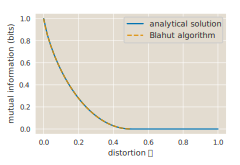

In [6]:
# Plot the D vs RD curve
plt.plot(dist_array, rate_distortion_array,
         label='analytical solution')
plt.plot(D_array, RD_array, label='Blahut algorithm',
         linestyle='--')

# Label axis
plt.xlabel('distortion $D$')
plt.ylabel('mutual information (bits)')

# Add legend
plt.legend(loc=0)

plt.tight_layout()

Our implementation of the Blahut algorithm perfectly tracks the close form solution for this memoryless binary channel with Hamming distance cost function. That gives us the confidence that the implementation of the algorithm is correct.

Now we turn our attention to defining a "biological distortion function."

## Defining the cost function as the distance from the optimal expression level

Before applying the algorithm we need to generate our distortion function $d(c, p)$. In the information theory context this function tells us the distortion of a message by mapping an input character $x_i$ with an output character $y_j$. Imagine for example we have a one-to-one mapping from one alphabet $\mathcal{X}$ to another alphabet $\mathcal{Y}$. Then the distortion function would tell us the cost of confusing let's say a $b$ for a $w$.

In general the distortion function is a "performance metric" that has the constraint that it must be strictly positive. In our context the distortion function $d(c, p)$ will be defined as the absolute difference between the growth rate at optimal expression level $f(c, p^*)$ and the actual growth rate for a given $p$. Let's define this function.

In [7]:
def abs_fitness_opt(c, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8, mu=1.15):
    '''
    Computes the absolute fitness when evaluated at the optimal relative 
    expression level p* for a given input concetration c, according to
    Dekel and Alon's 2005 fitness landscape.
    Parameters
    ----------
    c : array-like.
        Substrate concentration. If logC==True this is defined as log10(C)
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function
    mu : float.
        Absolute growth rate of reference strain
    
    Returns
    -------
    popt : array-like.
        The optimal relative expression level for a given input c.
    '''
    # Compute optimal expression level
    popt = utils.model.p_opt(c, delta, Ks, eta_o, M)
    
    # Compute optimal growth rate
    return utils.model.abs_fitness(popt, c, delta, Ks, eta_o, M, mu)

def growth_diff_c(p_rel, c, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8,
                  mu=1.15):
    '''
    Returns the difference between the growth rate r(C, m) and the optimal
    growth rate r_max(C).

    Parameter
    ---------
    Parameter
    ---------
    p_rel : array-like.
        Relative expression with respect to the wild type expression when
        fully induced with IPTG.
    C_array : array-like.
        Substrate concentration. If logC==True this is defined as log10(C)
    delta : float.
        growth benefit per substrate cleaved per enzyme.
    Ks : float.
        Monod constant for half maximum growth rate.
    eta_o : float.
        Parameter of the cost function
    M : float.
        Parameter of the cost function
    mu : float.
        Absolute growth rate of reference strain

    Returns
    -------
    growth_diff : array-like.
        difference between relative growth rate and the maximum 
        relative growth rate.
    ''' 
    # Compute the optimal expression level for each input
    rc_max = abs_fitness_opt(c, delta, Ks, eta_o, M)
    
    # Compute the non-optimal expression levels
    rcp = utils.model.abs_fitness(p_rel, c, delta, Ks, eta_o, M, mu)
    
    # Return the difference between these two growth rates
    return rc_max - rcp

And now let's plot this cost function to see how it looks.

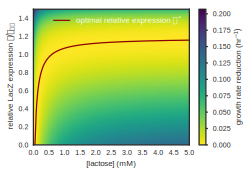

In [8]:
# Define the sugar concentrations grid
c_min = 0
c_max = 5
C_array = np.linspace(c_min, c_max, 500)

# Define the relative expressions to evaluate
p_rel_min = 0
p_rel_max = 1.5
p_rel = np.linspace(p_rel_min, p_rel_max, 501)

CC, pp = np.meshgrid(C_array, p_rel)
growth_diff = growth_diff_c(pp, CC)

with sns.axes_style('white'):
    fig = plt.figure()
    ax = plt.subplot(111)
    cax = ax.matshow(growth_diff, cmap=cm.viridis_r,
                    origin='lower',
                    extent=(c_min, c_max, p_rel_min, p_rel_max),
                    aspect='auto')
    ax.plot(C_array, utils.model.p_opt(C_array),
            label=r'optimal relative expression $p^*$',
            color='darkred')
    # Format plot
    # Set plot limits
    ax.set_xlim([c_min, c_max])
    ax.set_ylim([p_rel_min, p_rel_max])
    
    # Add axis labels
    ax.set_xlabel(r'[lactose] (mM)')
    ax.set_ylabel(r'relative LacZ expression $p / p_{wt}$')
    # Change default position of axis ticks
    ax.get_xaxis().set_ticks_position('bottom')
    
    # Add legend
    leg = ax.legend(loc=0, frameon=False)
    # Changing the color of the legend text
    for text in leg.get_texts():
        text.set_color("white")
    # Change default position of axis ticks
    ax.get_xaxis().set_ticks_position('bottom')
    
    # Set the ticks in both axis
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end + 0.1, 0.5))
    
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end + 0.1, 0.2))
    
    # Remove tick lines but still show labels
    ax.tick_params(axis='both', which='both',length=0, pad=5)
    
    # Add color-bar
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel(r'growth rate reduction (hr$^{-1})$')
    cbar.ax.tick_params(axis='both', which='both',length=2, pad=5)

This looks like the right trend. The further away the expression is from the optimal, the higher the price that is paid in terms of growth rate reduction.

For completeness let's repeat this calculation having the lactose concentration in log scale.

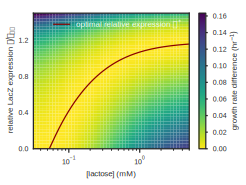

In [9]:
# Define the sugar concentrations and the relative expressions to evaluate
c_min_log = -1.5 # The minimum concentration at which there's a benefit
c_max_log = np.log10(5)
C_array_log = np.logspace(c_min_log, c_max_log, 50)

# Define the the relative expressions to evaluate
p_rel_min_log = 0
p_rel_max_log = 1.5
p_rel_log = np.linspace(p_rel_min_log, p_rel_max_log, 51)

# Generate meshgrid to evaluate function
CC, pp = np.meshgrid(C_array_log, p_rel_log)

# Evaluate distortion function
growth_diff = growth_diff_c(pp, CC)
    
with sns.axes_style('white'):
    fig = plt.figure()
    ax = plt.subplot(111)
    # Plot growth difference
    cax = ax.pcolormesh(C_array_log, p_rel_log,
                        growth_diff[:-1, :-1], 
                        cmap=cm.viridis_r)
    # Plot optimal expression level
    ax.plot(C_array_log, utils.model.p_opt(C_array_log), 
            label=r'optimal relative expression $p^*$',
            color='darkred')
    
    # Set log scale for x axis
    ax.set_xscale('log')
    
    # Set x axis ticks
    ax.tick_params(axis='x', which='minor', length=2, pad=5)
    ax.tick_params(axis='x', which='major', length=4, pad=5)
    
    # Set y axis ticks
    ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(4))
    
    # Set axis labels
    ax.set_xlabel(r'[lactose] (mM)')
    ax.set_ylabel(r'relative LacZ expression $p / p_{wt}$')
    
    # Add legend
    leg = ax.legend(loc=0, frameon=False)
    # Changing the color of the legend text
    for text in leg.get_texts():
        text.set_color("white")
    # Change default position of axis ticks
    ax.get_xaxis().set_ticks_position('bottom')
    
    # Add color-bar
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel(r'growth rate difference (hr$^{-1})$')
    cbar.ax.tick_params(axis='both', which='both',length=2, pad=5)

Everything looks fine! Let's apply this cost function to see what we find out.

## Testing the Blahut algorithm with a biological distortion function.

Now that we have our distortion function $d(c, p)$, we just need to define a function to set the environemnt distribution $P(c)$. As a first example let's use a log-uniform distribution over environments.

In [10]:
# Define array of concentrations in log-scale
c_min_log = -1.5 # The minimum concentration at which there's a benefit
c_max_log = 0
C_array_log = np.logspace(c_min_log, c_max_log, 10)

# Define probability distribution for inputs to be
# Log-uniform
Pc = [1 / len(C_array_log)] * len(C_array_log)

Now let's compute the distortion function for a grid of relative expressions

In [11]:
# Define the the relative expressions to evaluate
p_rel_min_log = 0
p_rel_max_log = 1.5
p_rel_log = np.linspace(p_rel_min_log, p_rel_max_log, 10000)

# Generate meshgrid to evaluate function
CC, pp = np.meshgrid(C_array_log, p_rel_log)

# Evaluate distortion function
growth_diff = growth_diff_c(pp, CC)

We now have everything ready to test the Blahut algorithm.

In [12]:
# Define value of parameters beta for the Blahut algorithm
beta = np.linspace(-2000, 0, 250)

# Set boolean to determine if calculation should be performed or not
compute_RD = True

if compute_RD:
    # Define function to compute rate distortion function in parallel
    def RD_parallel(beta):
        return rate_dist(Pc=Pc, rho_cp=growth_diff, beta=beta)
    # Run the function in parallel
    RD_list = Parallel(n_jobs=6)(delayed(RD_parallel)(b)
                                 for b in beta)
    
# Iinitialize array to separate D and RD from the list
D = np.zeros_like(beta)
RD = np.zeros_like(beta)
# Loop through results of the parallel run to split elements
for i, rd in enumerate(RD_list):
    RD[i] = rd[-1]
    D[i] = rd[-2]

In order to display this result in a meaningful way that concerns our evolutionary question we will plot the mutual information between input and output $I(c;p)$ versus the average growth rate. The average growth rate in this case is defined as the average maximum growth rate $\ee{r}_\max$ minus the average distortion $D$.

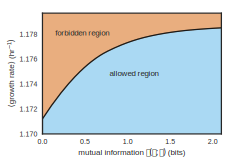

In [13]:
# Compute <r>_max for the distribution of environments
abs_fitness = abs_fitness_opt(C_array_log)
r_avg_max = np.sum(abs_fitness * Pc)

# Set white background for this plot
with sns.axes_style('white'):
    # Plot the minimum amout of information vs the average growth rate
    plt.plot(RD, r_avg_max - D, color='k')
    # show with cyan the allowed region
    plt.fill_between(RD, r_avg_max - D, 0, 
                     color='c', alpha=0.5)
    plt.text(0.15, 0.8, 'forbidden region', horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=8)
    # show with red the prohibited region
    plt.fill_between(RD, 2, r_avg_max - D, 
                     color='r', alpha=0.5)
    plt.text(0.5, 0.5, 'allowed region',
             horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=8)
    
# Set axis limits
plt.xlim([min(RD), max(RD)])
plt.ylim([1.17, max(r_avg_max - D) * 1.001])

# Lable plot
plt.xlabel('mutual information $I(p; c)$ (bits)')
plt.ylabel(r'$\left\langle \right.$' + 
           r'growth rate' +
           r'$\left. \right\rangle$ (hr$^{-1})$')

plt.tight_layout()

---

## Placing experimental strains into the information vs. fitness plane

Let's map our theoretical predictions of the input-output function $P(p \mid c)$ for the simple repression motif into our information and fitness plane. For now, since we are using the Dekel and Alon fitness model we need to map our model parameters into their entry. For example, for their relative expression the maximum expression that the cells are able to sustain is 1.8 times what the fully induced strain expresses. We will take this uper bound to be the highest protein copy number of $\approx 2\times 10^4$ proteins per cell.  For the environemtnal concentration state $c$, our experimental setup used 12 different concentrations of IPTG for the induction level spanning from 0 to 5000 $\mu$M. Since Dekel and Alon use the exact same range for Lactose we will map our concentrations of inducer directly to the lactose concentrations.

Let's first repeat the above calculation, this time using the 12 experimental concentrations with a log-uniform distribution. We will import the file containing the Lagrange multipliers to reconstruct the input-output function.

In [14]:
# Import Lagrange multipliers to build the protein distributions
df_maxEnt_prot = pd.read_csv('../../data/maxent/MaxEnt_Lagrange_mult_protein.csv')

df_maxEnt_prot.head(3)

,operator,binding_energy,repressor,inducer_uM,lambda_m0p1,lambda_m0p2,lambda_m0p3,m1p0,m1p1,m1p2,...,m3p0,m3p1,m3p2,m3p3,m4p0,m4p1,m4p2,m5p0,m5p1,m6p0
0,O1,-15.3,0.0,0.0,0.000309,-1.632168e-08,-8.780785e-14,16.092691,159058.599136,1.891230e+09,...,9290.230622,1.018551e+08,1.259305e+12,1.661111e+16,298145.197168,3.373151e+09,4.226007e+13,1.099902e+07,1.271531e+11,4.541650e+08
1,O1,-15.3,0.0,0.1,0.000309,-1.632168e-08,-8.780785e-14,16.092691,159058.599136,1.891230e+09,...,9290.230622,1.018551e+08,1.259305e+12,1.661111e+16,298145.197168,3.373151e+09,4.226007e+13,1.099902e+07,1.271531e+11,4.541650e+08
2,O1,-15.3,0.0,5.0,0.000309,-1.632168e-08,-8.780785e-14,16.092691,159058.599136,1.891230e+09,...,9290.230622,1.018551e+08,1.259305e+12,1.661111e+16,298145.197168,3.373151e+09,4.226007e+13,1.099902e+07,1.271531e+11,4.541650e+08


Now let's extract the unique inducer concentrations and generate the log uniform distribution to compute the information-fitness plane.

In [15]:
# Extract unique inducer concentrations
c = df_maxEnt_prot.inducer_uM.unique()

# Compute uniform distribution
Pc = [1 / len(c)] * len(c)

# Map expression levels into relative expressions
p_array = np.arange(0, 1.8E4)  # absolute protein count
p_rel = p_array / max(p_array)

# Generate meshgrid to evaluate function
CC, pp = np.meshgrid(c, p_rel)

# Evaluate distortion function
growth_diff = growth_diff_c(pp, CC)

# Define value of parameters beta for the Blahut algorithm
beta = np.linspace(-2000, 0, 250)

# Set boolean to determine if calculation should be performed or not
compute_RD = True

if compute_RD:
    # Define function to compute rate distortion function in parallel
    def RD_par(i, beta):
        if i%25 == 0:
            print('cycle {:d}'.format(i))
        return rate_dist(Pc=Pc, rho_cp=growth_diff, beta=beta)
    # Run the function in parallel
    RD_list = Parallel(n_jobs=6)(delayed(RD_par)(i, b)
                                 for i, b in enumerate(beta))
    
# Iinitialize array to separate D and RD from the list
D = np.zeros_like(beta)
RD = np.zeros_like(beta)
# Loop through results of the parallel run to split elements
for i, rd in enumerate(RD_list):
    RD[i] = rd[-1]
    D[i] = rd[-2]

Let's take a look at this information vs. fitness plane for our experimental concentrations.

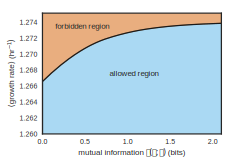

In [19]:
# Compute <r>_max for the distribution of environments
r_avg_max = abs_fitness_opt(c)
r_avg_max = np.sum(r_avg_max * Pc)

# Set white background for this plot
with sns.axes_style('white'):
    # Plot the minimum amout of information vs the average growth rate
    plt.plot(RD, r_avg_max - D, color='k')
    # show with cyan the allowed region
    plt.fill_between(RD, r_avg_max - D, 0, 
                     color='c', alpha=0.5)
    plt.text(0.15, 0.85, 'forbidden region', horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=8)
    # show with red the prohibited region
    plt.fill_between(RD, 2, r_avg_max - D, 
                     color='r', alpha=0.5)
    plt.text(0.5, 0.5, 'allowed region',
             horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=8)
    
# Set axis limits
plt.xlim([min(RD), max(RD)])
plt.ylim([1.26, max(r_avg_max - D) * 1.001])

# Lable plot
plt.xlabel('mutual information $I(p; c)$ (bits)')
plt.ylabel(r'$\left\langle \right.$' + 
           r'growth rate' +
           r'$\left. \right\rangle$ (hr$^{-1})$')

plt.tight_layout()

#### Computing the mutual information between environment and gene expression.

With the input-output function $P(p \mid c)$ approximated using a chemical master equation approach we can then compute the mutual information between input and outputs. The mutual information is given by
\begin{equation}
    I(c; p) = \sum_c P(c) \sum_p P(p \mid c) \log_2 \left[ \frac{P(p \mid c)}{P(p)} \right],
\end{equation}
where the probability $P(p)$ must obey
\begin{equation}
    P(p) = \sum_c P(c) P(p \mid c).
\end{equation}

Lets define a function to compute this quantity given an input-output function $P(p \mid c)$ and an input distribution $P(c)$.

In [71]:
def mutual_info(Pc, Ppc, cutoff=1E-10):
    '''
    Computes the mutual information given an input distribution P(c)
    and an input output funciton P(p | c).
    
    Parameters
    ----------
    Pc : array-like.
        Array containing the distribution of the inputs
    Ppc : 2D array.
        Input-output conditional probability distribution P(p | c)
    cutoff : float.
        necessary lower bound to determine when to ignore a term in the
        sum given the convention that 0 x log0 = 0.
    
    Returns
    -------
    The mutual information between the gene expession and the environment
    distribution in bits.
    '''
    # Since we'll need 2D integrals, make a mesh of input probability
    Pc_tile = np.tile(Pc, (Ppc.shape[0], 1))
    
    # Build P(p) by marginalizing P(c) * P(p|c) over c.
    Pp = np.sum(Ppc * Pc_tile, axis=1).astype(float)
    Pp_tile = np.tile(Pp, (len(Pc), 1)).T

    # Make P(p|c) * log(P(p|c)) making sure no log(0).
    Ppc_log_Ppc = np.zeros_like(Ppc)
    Ppc_log_Ppc[Ppc > cutoff] = Ppc[Ppc > cutoff] * np.log2(Ppc[Ppc > cutoff])
    
    # Make P(p|c) * log(P(p)) making sure no log(0).
    Ppc_log_Pp = np.zeros_like(Ppc)
    Ppc_log_Pp[Pp_tile > cutoff] = \
            Ppc[Pp_tile > cutoff] * np.log2(Pp_tile[Pp_tile > cutoff])
    
    # sum over p
    int_p = np.sum(Ppc_log_Ppc - Ppc_log_Pp, axis=0).astype(float)
    
    # Return sum over c
    return sum(Pc * int_p).astype(float)

In order to apply this function we need to reconstruct the input-output function $P(p \mid c)$ from the Lagrange multipliers that we previously obtained from the maximum entropy approximation of these distributions. For this we now define a function to reconstruct these distributions. The function is more general in the sense that it can reconstruct either the mRNA or the protein distribution.

In [32]:
def trans_matrix(df_lagrange, mRNA_space, protein_space, m_dist=True):
    '''
    Function that builds the transition matrix Qg|c for a series of
    concentrations c. It builds the matrix by using the tidy data-frames
    containing the list of Lagrange multipliers.
    
    Parameters
    ----------
    df_lagrange : pandas DataFrame.
        Data Frame containing the lagrange multipliers for a single straing,
        i.e. single operator and repressor copy number value.
    mRNA_space, protein_space : array-like.
        Array containing the sample space for the mRNA and the protein
        respectively
    m_dist : Bool. Default = True.
        Boolean indicating if the mRNA input-output matrix should be returned.
        If false the protein matrix is returned.
    
    Returns
    -------
    Qg|c : input output matrix in which each row represents a concentration
    and each column represents the probability of mRNA or protein copy number.
    '''
    # Extract unique concentrations
    c_array = df_lagrange['inducer_uM'].unique()
    
    # Extract the list of Lagrange multipliers
    lagrange_mult = [col for col in df_lagrange.columns if 'lambda' in col]
    # Extract the exponents corresponding to each Lagrange multiplier
    exponents = []
    for s in lagrange_mult:
        exponents.append([int(n) for n in list(s) if n.isdigit()])
    
    # Initialize input-output matrix
    if m_dist:
        Qgc = np.zeros([len(mRNA_space), len(c_array)])
    else:
        Qgc = np.zeros([len(protein_space), len(c_array)])
    
    # Group data frame by inducer concentration
    df_group = df_lagrange.groupby('inducer_uM')
    
    # Loop through each of the concentrations computing the distribution
    for i, (group, data) in enumerate(df_group):
        # Extract the Lagrange multiplier columns
        lagrange = data.loc[:, lagrange_mult].values[0]
        
        # Compute the distribution
        Pmp = utils.maxent.maxEnt_from_lagrange(mRNA_space, protein_space, 
                                             lagrange,
                                             exponents=exponents)
        
        # Marginalize and add marignal distribution to Qg|c
        if m_dist:
            Qgc[:, i] = Pmp.sum(axis=0)
        else:
            Qgc[:, i] = Pmp.sum(axis=1)
            
    return Qgc

Let's test the function with a strain that we expect to have no information about the environment. This is a strain with a weak binding site and a small number of repressors that, due to its leaky expression, it does not differentially respond to the different induction levels.

In [75]:
# Extract sample data frame
df_lagrange = df_maxEnt_prot[(df_maxEnt_prot.operator == 'O3') &
                             (df_maxEnt_prot.repressor == 22)]

# Define sample space
mRNA_space = np.array([0])  # Dummy space
protein_space = np.arange(0, 4E4)

# Build input-output matrix Qg|c
Ppc = trans_matrix(df_lagrange, mRNA_space, protein_space, False)

# Print mutual information with the log-uniform distribution
print('O3 R22 strain')
print('I(c;p) = {:.2f} bits'.format(mutual_info(Pc, Ppc)))

O3 R22 strain
I(c;p) = 0.00 bits


As expected this strain has no mutual information between input and output. Let's now systematically compute this mutual information and the average growth rate for each of the strains for which we have a prediction of the input-output function.

In [86]:
# Map expression levels into relative expressions
p_rel = protein_space / max(protein_space)

# Generate meshgrid to evaluate function
CC, pp = np.meshgrid(c, p_rel)

# Evaluate distortion function
fitness = utils.model.abs_fitness(pp, CC)

# Group data frame by operator and repressor copy number
df_group = df_maxEnt_prot.groupby(['operator', 'repressor'])

# Initialize data frame to save results
names = ['operator', 'repressor', 'mutual_info', 'avg_growth_rate']
df_fit = pd.DataFrame(columns=names)

# Loop through groups computing mutual information and average growth rate
for i, (group, data) in enumerate(df_group):
    # Build input-output matrix Pp|c
    Ppc = trans_matrix(data, mRNA_space, protein_space, False)
    
    # Compute mutual information
    mi = mutual_info(Pc, Ppc)
    
    # Compute average growth rate
    Ppc_fpc = Ppc * fitness  # P(p | c) * f(c, p)
    sum_p = np.sum(Ppc_fpc, axis=0)  # ∑_p P(p | c) * f(c, p)
    avg_r = np.sum(Pc * sum_p)  # ∑_c P(c) ∑_p P(p | c) * f(c, p)
    
    # Save result in pandas series to append to dataframe
    series = pd.Series([group[0], group[1], mi, avg_r], index=names)
    
    # Append series to data frame
    df_fit = df_fit.append(series, ignore_index=True)

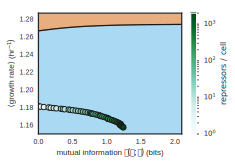

In [100]:

# Set white background for this plot
with sns.axes_style('white'):
    # Plot the minimum amout of information vs the average growth rate
    plt.plot(RD, r_avg_max - D, color='k')
    # show with cyan the allowed region
    plt.fill_between(RD, r_avg_max - D, 0, 
                     color='c', alpha=0.5)
    # show with red the prohibited region
    plt.fill_between(RD, 2, r_avg_max - D, 
                     color='r', alpha=0.5)
    
# Plot strains over information plane
df = df_fit[df_fit.operator == 'O2']
R_array = df.repressor.values
cax = plt.scatter(df.mutual_info, df.avg_growth_rate,
                  c=R_array, cmap=cm.BuGn, s=30,
                  edgecolors='k',
                  norm=matplotlib.colors.LogNorm())
    
# Set axis limits
plt.xlim([min(RD), max(RD)])
plt.ylim([1.15, max(r_avg_max - D) * 1.01])

# Lable plot
plt.xlabel('mutual information $I(p; c)$ (bits)')
plt.ylabel(r'$\left\langle \right.$' + 
           r'growth rate' +
           r'$\left. \right\rangle$ (hr$^{-1})$')

# Add color bar for repressor copy number 
cbar = plt.colorbar(cax)
cbar.ax.set_ylabel(r'repressors / cell')
cbar.ax.tick_params(axis='both', which='both',length=2, pad=5)
    
plt.tight_layout()

## Cranking up the selection.

It will be interesting to modify the fitness landscape parameters in order to make the selection much stronger such that the vertical axis of the information/fitness plane increases significantly. Let's see how we could play with these parameters

In [ ]:
# param = dict(r_gamma=15.7, delta=0.17, Ks=0.4, eta_o=0.02, M=1.8)
param = dict(r_gamma=15.7, delta=1.7, Ks=0.4, eta_o=0.2, M=3)

# Define the grid on which integrate
C_grid = np.linspace(1E-4, 1, 100)
mRNA_grid = np.linspace(0, 15.7 * 1.5, 101)

CC, mm = np.meshgrid(C_grid, mRNA_grid)
growth_diff = growth_diff_C(CC, mm, **param)

# Redefine the normalized grid. Basically because I am lazy....
mRNA_grid = np.linspace(0, 15.7 * 1.5, 101) / param['r_gamma']

with sns.axes_style('white'):
    fig = plt.figure()
    ax = plt.subplot(111)
    cax = ax.matshow(growth_diff, cmap=cm.viridis_r,
                    origin='lower', extent=(C_grid.min(), C_grid.max(),
                                            mRNA_grid.min(), mRNA_grid.max()),
                    aspect='auto')
    ax.plot(C_grid, evo_utils.p_opt(C_grid),
            label=r'optimal relative expression $p^*$',
            color='darkred')
    # Format plot
    ax.set_xlim([C_grid.min(), C_grid.max()])
    ax.set_ylim([mRNA_grid.min(), mRNA_grid.max()])
    ax.set_xlabel(r'[lactose] mM')
    ax.set_ylabel(r'relative LacZ expression $p / p_{wt}$')
    # Change default position of axis ticks
    ax.get_xaxis().set_ticks_position('bottom')
    
    leg = ax.legend(loc='lower right', fontsize=12)
    # Changing the color of the legend text
    for text in leg.get_texts():
        text.set_color("white")

    # Add color-bar
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel(r'$r_\max (C) - r(p, C)$')
    
    plt.tight_layout()

This seems like a good set of parameters, let's see if the Blahut algorithm can converge given this scenario.

In [ ]:
# Define the grid on which integrate
C_grid = np.linspace(1E-8, 1, 100)
mRNA_grid = np.linspace(0, param['r_gamma'] * 1.5, 101)

# define the values of beta to test
beta = np.logspace(np.log10(1), np.log10(1000), 50)

compute_RD = True
if compute_RD:
    # # initialize arrays to save D and RD
    D_array = np.empty_like(beta)
    RD_array = np.empty_like(beta)
    pC_list = list()
    qm_list = list()
    QmC_list = list()
    for i, b in enumerate(beta):
        if i%5 == 0:
            print(i)
        pC, qm, rhoCm, QmC, D, RD = \
        rate_dist(C=C_grid, mRNA=mRNA_grid, beta=-b, 
                  PC_fun=evo_utils.PC_expo, fitness_fun=growth_diff_C, 
                  param=param, epsilon=5E-5, fitness_scale=1)
        D_array[i] = D
        RD_array[i] = RD
        pC_list.append(pC)
        qm_list.append(qm)
        QmC_list.append(QmC)

    # save output with pickle
    # open / create a .pkl file
    output = open(tmpdir + 'RD_expo_C_high_selection.pkl', 'wb')
    pickle.dump(D_array, output)
    pickle.dump(RD_array, output)
    pickle.dump(pC_list, output)
    pickle.dump(qm_list, output)
    pickle.dump(QmC_list, output)

# Load the pickled data
pkl_file = open(tmpdir + 'RD_expo_C_high_selection.pkl', 'rb')
D_array = pickle.load(pkl_file)
RD_array = pickle.load(pkl_file)
pC_list = pickle.load(pkl_file)
qm_list = pickle.load(pkl_file)
QmC_list = pickle.load(pkl_file)

param_opt = param.copy()
del param_opt['r_gamma']
# compute the average growth rate given this input distribution
avg_growth_opt = avg_growth_opt_C(C_grid, evo_utils.PC_expo, **param_opt)

In [ ]:
sns.set_color_codes()
with sns.axes_style('white'):
    # plot the limting line
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(RD_array, avg_growth_opt - D_array, 'k')
    
    # show with red the prohibited region
    ax.fill_between(RD_array, avg_growth_opt - D_array, 
                     0.5, 
                     color='r', alpha=0.5)
    ax.text(0.1, 0.9, 'forbidden region', horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    # show with green the allowed region
    ax.fill_between(RD_array, avg_growth_opt - D_array,
                    0.4, 
                     color='c', alpha=0.5)
    ax.text(0.5, 0.5, 'permissible region',
             horizontalalignment='left',
             verticalalignment='center',
             transform=ax.transAxes, fontsize=16)
    
    # label axis
    ax.set_ylabel(r'mean relative growth rate $\langle r \rangle$')
    ax.set_xlabel(r'mutual information [bits]')
    ax.set_title('exponential distribution')
    ax.set_xlim(right=RD_array.max())
    plt.savefig(outputdir + 'fitness_information_expo_high_selection.pdf')